# 🚀 Spacecraft Anomaly Challenge 

https://www.kaggle.com/competitions/esa-adb-challenge

El objetivo es diseñar un algoritmo capaz de detectar anomalías en señales multivariantes de sensores temporales. El desafío está organizado por la **European Space Agency (ESA)**.

📁 **Datos**

- ```train.parquet```: Datos sensorizados con etiquetas (_is_anomaly_).

- ```test.parquet```: Datos sin etiquetar.

- ```target_channels.csv```: Indica qué canales son relevantes para cada grupo de señales (id).

🎯 La predicción, para cada punto en el tiempo, será ```1``` si representa una **condición anómala** o ```0``` si está dentro de la normalidad (basándose en las variables ```channel_*```, que son las lecturas de los sensores).

---

Las propuestas de algoritmos recogidas en este documento han sido realizadas y probadas por:
- 👱🏼‍♂️ Miguel González
- 🧑 Javier Quesada


## 📦 Imports y dependencias

In [ ]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from ydata_profiling import ProfileReport

from sklearn.ensemble import IsolationForest
import xgboost as xgb

import keras
from keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

In [2]:
TRAIN_FILE = "data/train.parquet"
TEST_FILE = "data/test.parquet"

## 🧰 Preprocesamiento

En esta sección cargaremos el dataset de entrenamiento e iremos estudiando y visualizando sus peculiaridades; procesándolo en consecuencia.

Por limitaciones de computación, solo hemos trabajado con los principales 6 canales para la detección de anomalías: ```channel_41``` a ```channel_46```.

In [3]:
starter_ch = [f"channel_{i}" for i in range(41, 47)]

df_train = pd.read_parquet(
    TRAIN_FILE,
    columns=["id", "is_anomaly"] + starter_ch
)

df_test = pd.read_parquet(
    TEST_FILE,
    columns=["id"] + starter_ch
)

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
df_train.head()

Train shape: (14728321, 8)
Test shape: (521280, 7)


,id,is_anomaly,channel_41,channel_42,channel_43,channel_44,channel_45,channel_46
0,0,0,0.812578,0.786344,0.771900,0.799178,0.816855,0.765296
1,1,0,0.812578,0.786344,0.771900,0.799178,0.816855,0.765296
2,2,0,0.821213,0.789557,0.770317,0.809411,0.816006,0.765296
3,3,0,0.819642,0.786344,0.770317,0.807050,0.816855,0.766985
4,4,0,0.821996,0.788753,0.770317,0.807837,0.818551,0.761073


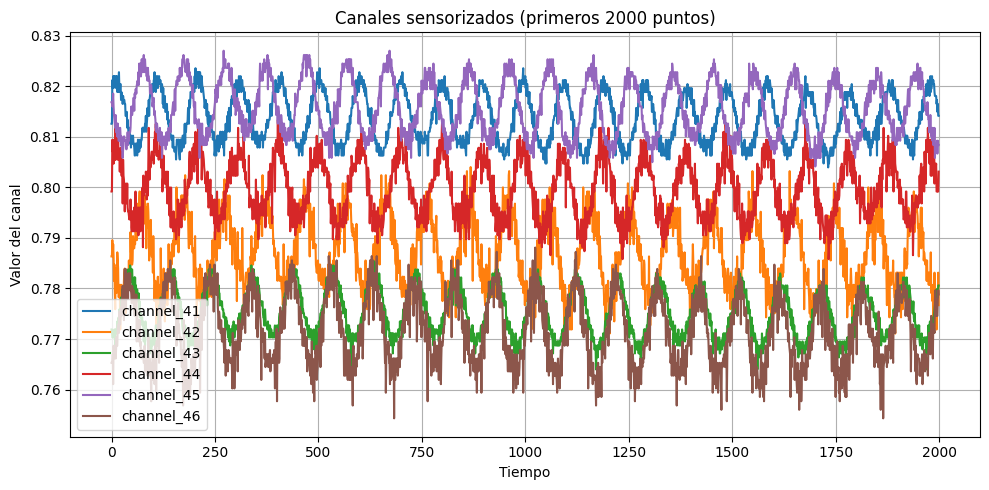

In [4]:
plt.figure(figsize=(10, 5))
for ch in starter_ch:
    plt.plot(df_train[ch].iloc[:2000], label=ch)

plt.title("Canales sensorizados (primeros 2000 puntos)")
plt.xlabel("Tiempo")
plt.ylabel("Valor del canal")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

En esta gráfica se representan los valores de los 6 canales sensorizados (```channel_41``` a ```channel_46```) durante los primeros 2.000 instantes temporales de la serie.

Se observa un comportamiento periódico y cíclico de cada uno de los canales. En el instante capturado en la gráfica parece que mantienen ese patrón a lo largo del tiempo, lo que, en un principio, puede facilitar el pronóstico.

In [ ]:
# profile = ProfileReport(df_train, title="Profiling Report")
# profile.to_file("report.html")

Tras visualizar el reporte, se puede confirmar que los valores 0.0 están muy lejos del resto de valores normales que tienen los canales. Esto implica que estos ceros son errores en la detección y deben ser eliminados.

C:\Users\javiq\AppData\Local\Temp\ipykernel_7468\1927373237.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
c:\Users\javiq\anaconda3\envs\tf_esa\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


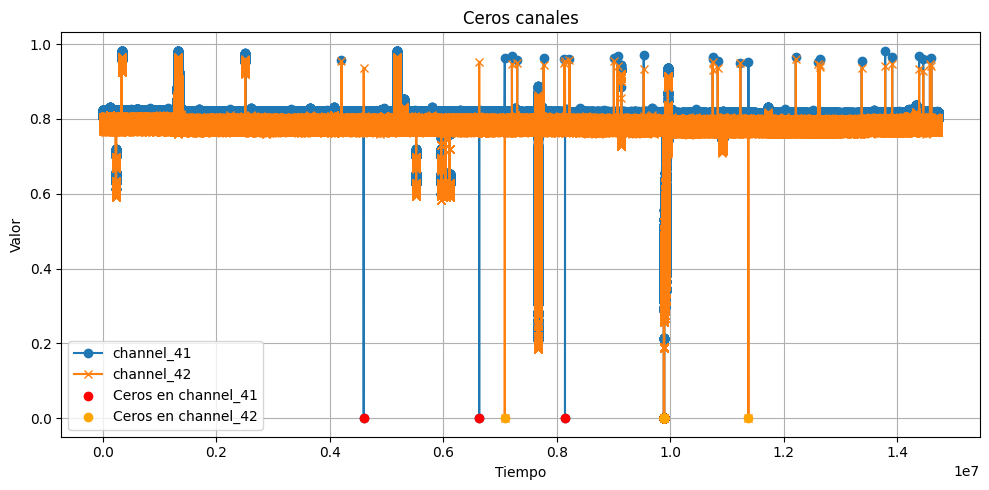

In [5]:
plt.figure(figsize=(10, 5))
plt.plot(df_train["channel_41"], label="channel_41", marker='o')
plt.plot(df_train["channel_42"], label="channel_42", marker='x')
plt.scatter(df_train.index[df_train["channel_41"] == 0], df_train["channel_41"][df_train["channel_41"] == 0],
            color='red', label="Ceros en channel_41", zorder=5)
plt.scatter(df_train.index[df_train["channel_42"] == 0], df_train["channel_42"][df_train["channel_42"] == 0],
            color='orange', label="Ceros en channel_42", zorder=5)
plt.title("Ceros canales")
plt.xlabel("Tiempo")
plt.ylabel("Valor")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

En esta gráfica se muestran los valores de los canales ```channel_41``` y ```channel_42``` a lo largo del conjunto de entrenamiento completo. Las marcas rojas y naranjas destacan los puntos donde el valor del canal es exactamente 0.0, lo cual se interpreta como un valor erróneo introducido por el sensor.

Estos valores cero rompen completamente el patrón continuo de la señal y aparecen de forma abrupta.

Es por eso por lo que se ha decidido tratarlos como valores faltantes, tratándolos con métodos de **forward-fill** y **backward-fill** para no afectar la calidad del entrenamiento de los modelos.

<b>LOCF/FOCB</b> es muy rápido en series largas y no inventa valores nuevos, simplemente replica un valor cercano. Además, los ceros representan menos del 0.1% de los datos del canal, por lo que una sustitución simple no supone un gran cambio.

In [4]:
# canales con ceros
zero_counts = (df_train[starter_ch] == 0.0).sum()
zero_chs = zero_counts[zero_counts > 0].index.tolist()

# reemplaza 0.0 con NaN
df_train[zero_chs] = df_train[zero_chs].replace(0.0, np.nan)

# forward-fill y backward-fill
df_train[zero_chs] = df_train[zero_chs].ffill().bfill()

print("NaNs:", df_train[zero_chs].isna().sum().sum())

NaNs: 0


In [7]:
print(df_train.dtypes)

id              int64
is_anomaly      uint8
channel_41    float32
channel_42    float32
channel_43    float32
channel_44    float32
channel_45    float32
channel_46    float32
dtype: object


Se escalan los datos, que puede ser necesario en algunos modelos.

In [5]:
scaler = StandardScaler()

df_train[starter_ch] = scaler.fit_transform(df_train[starter_ch])

Separación del 80 % train y 20 % validation

In [6]:
split = int(len(df_train) * 0.8)

train_df = df_train.iloc[:split].reset_index(drop=True)
val_df   = df_train.iloc[split:].reset_index(drop=True)

X_train = train_df[starter_ch]
y_train = train_df["is_anomaly"]
X_val   = val_df[starter_ch]
y_val   = val_df["is_anomaly"]

Métrica de evaluación Event-Wise F0.5

In [8]:
def event_wise_fbeta_score(y_true, y_pred, beta=0.5, correct_precision=True):
    def get_events(y):
        events, in_event = [], False
        for i, v in enumerate(y):
            if v and not in_event:
                start, in_event = i, True
            elif not v and in_event:
                events.append((start, i-1)); in_event = False
        if in_event: events.append((start, len(y)-1))
        return events

    true_events = get_events(y_true)
    pred_events = get_events(y_pred)

    TPe = sum(1 for a,b in true_events if np.any(y_pred[a:b+1]==1))
    FNe = len(true_events) - TPe
    FPe = sum(1 for a,b in pred_events if not np.any(y_true[a:b+1]==1))

    FP_pts = np.sum((y_pred==1)&(y_true==0))
    N_nom   = np.sum(y_true==0)

    if correct_precision:
        prec = TPe / (TPe + FPe + FP_pts/max(1,N_nom))
    else:
        prec = TPe / max(1, TPe+FPe)
    rec = TPe / max(1, TPe+FNe)

    beta2 = beta**2
    return 0.0 if (prec+rec)==0 else (1+beta2)*(prec*rec)/(beta2*prec+rec)

## 🏋️ Entrenamiento y prueba de modelos

### 🌳 Modelos basados en árboles 

Creación de ventanas. Se usan características auxiliares como la media, la desviación, etc. para aumentar información

In [11]:
#valor de ventana
W = 100

#se crea ña rolling window sobre X_train
roll_train = X_train.rolling(window=W, min_periods=1)
X_train_feat = pd.DataFrame(index=X_train.index)

for ch in starter_ch:
    X_train_feat[f"{ch}_mean_{W}"] = roll_train[ch].mean()
    X_train_feat[f"{ch}_std_{W}"]  = roll_train[ch].std().fillna(0)
    X_train_feat[f"{ch}_min_{W}"]  = roll_train[ch].min()
    X_train_feat[f"{ch}_max_{W}"]  = roll_train[ch].max()
    X_train_feat[f"{ch}_diff"]     = X_train[ch].diff().fillna(0)

#se crea la rolling window sobre X_val
roll_val = X_val.rolling(window=W, min_periods=1)
X_val_feat = pd.DataFrame(index=X_val.index)

for ch in starter_ch:
    X_val_feat[f"{ch}_mean_{W}"] = roll_val[ch].mean()
    X_val_feat[f"{ch}_std_{W}"]  = roll_val[ch].std().fillna(0)
    X_val_feat[f"{ch}_min_{W}"]  = roll_val[ch].min()
    X_val_feat[f"{ch}_max_{W}"]  = roll_val[ch].max()
    X_val_feat[f"{ch}_diff"]     = X_val[ch].diff().fillna(0)

#verificar shapes
print("Train features shape:", X_train_feat.shape)
print("Val   features shape:", X_val_feat.shape)

Train features shape: (11782656, 30)
Val   features shape: (2945665, 30)


In [14]:
X_train_feat.head()

,channel_41_mean_100,channel_41_std_100,channel_41_min_100,channel_41_max_100,channel_41_diff,channel_42_mean_100,channel_42_std_100,channel_42_min_100,channel_42_max_100,channel_42_diff,...,channel_45_mean_100,channel_45_std_100,channel_45_min_100,channel_45_max_100,channel_45_diff,channel_46_mean_100,channel_46_std_100,channel_46_min_100,channel_46_max_100,channel_46_diff
0,0.188399,0.000000,0.188399,0.188399,0.000000,0.175212,0.000000,0.175212,0.175212,0.000000,...,0.292642,0.000000,0.292642,0.292642,0.000000,-0.052281,0.000000,-0.052281,-0.052281,0.000000
1,0.188399,0.000000,0.188399,0.188399,0.000000,0.175212,0.000000,0.175212,0.175212,0.000000,...,0.292642,0.000000,0.292642,0.292642,0.000000,-0.052281,0.000000,-0.052281,-0.052281,0.000000
2,0.338087,0.259267,0.188399,0.637463,0.449064,0.228770,0.092765,0.175212,0.335887,0.160674,...,0.278190,0.025031,0.249287,0.292642,-0.043355,-0.052281,0.000000,-0.052281,-0.052281,0.000000
3,0.392512,0.238037,0.188399,0.637463,-0.081675,0.215381,0.080337,0.175212,0.335887,-0.160674,...,0.281803,0.021677,0.249287,0.292642,0.043355,-0.030981,0.042600,-0.052281,0.032919,0.085200
4,0.449655,0.242534,0.188399,0.678227,0.122439,0.231448,0.078303,0.175212,0.335887,0.120506,...,0.301300,0.047465,0.249287,0.379285,0.086642,-0.077841,0.111086,-0.265278,0.032919,-0.298197


Escalado de las feats

In [12]:
scaler_feat = StandardScaler()
X_train_feat_scaled = scaler_feat.fit_transform(X_train_feat)
X_val_feat_scaled   = scaler_feat.transform(X_val_feat)

Preprocesado y generación de ventanas para el test

In [18]:
# Preprocesado
df_test_proc = df_test.copy()
zero_chs_test = [ch for ch in starter_ch if (df_test_proc[ch]==0.0).any()]
df_test_proc[zero_chs_test] = df_test_proc[zero_chs_test].replace(0.0, np.nan).ffill().bfill()
df_test_proc[starter_ch] = scaler.transform(df_test_proc[starter_ch])

# Generación de ventanas
roll_te = df_test_proc[starter_ch].rolling(window=W, min_periods=1)
X_test_feat = pd.DataFrame(index=df_test_proc.index)
for ch in starter_ch:
    X_test_feat[f"{ch}_mean"] = roll_te[ch].mean()
    X_test_feat[f"{ch}_std"]  = roll_te[ch].std().fillna(0)
    X_test_feat[f"{ch}_min"]  = roll_te[ch].min()
    X_test_feat[f"{ch}_max"]  = roll_te[ch].max()
    X_test_feat[f"{ch}_diff"] = df_test_proc[ch].diff().fillna(0)

X_test_scaled = scaler_feat.transform(X_test_feat)

c:\Users\javiq\anaconda3\envs\tf_esa\lib\site-packages\sklearn\utils\validation.py:2732: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


#### Isolation Forest (Public Score: 0.192)

Se busca la mejor contaminación en validación.

In [16]:
contamination_values = [0.008, 0.009, 0.010, 0.012, 0.015]
best_f05, best_cont = 0, None

for cont in contamination_values:
    clf = IsolationForest(
        n_estimators=100,
        contamination=cont,
        n_jobs=-1,
        random_state=42
    )
    clf.fit(X_train_feat_scaled)

    preds = (clf.predict(X_val_feat_scaled)==-1).astype(int)

    f05 = event_wise_fbeta_score(y_val.values, preds, beta=0.5)

    print(f"cont={cont:.3%}. F0.5 = {f05:.4f}")

    if f05 > best_f05:
        best_f05, best_cont = f05, cont

print(f"Mejor cont = {best_cont:.3%}. F0.5 = {best_f05:.4f}")

C:\Users\javiq\AppData\Local\Temp\ipykernel_7468\411405165.py:23: RuntimeWarning: invalid value encountered in scalar divide
  prec = TPe / (TPe + FPe + FP_pts/max(1,N_nom))


cont=0.800%. F0.5 = nan
cont=0.900%. F0.5 = 0.4839
cont=1.000%. F0.5 = 0.6410
cont=1.200%. F0.5 = 0.6707
cont=1.500%. F0.5 = 0.0302
Mejor cont = 1.200%. F0.5 = 0.6707


Entreno final del modelo con todos los datos

In [17]:
# Concatena train+val
X_full_feat = np.vstack([X_train_feat, X_val_feat])
X_full_scaled = scaler_feat.fit_transform(X_full_feat)

# Entrena el modelo
clf_full = IsolationForest(
    n_estimators=100,
    contamination=best_cont,
    n_jobs=-1,
    random_state=42
)
clf_full.fit(X_full_scaled)

IsolationForest(contamination=0.012, n_jobs=-1, random_state=42)

Predicción y generación de CSV

In [19]:
preds_test_if = (clf_full.predict(X_test_scaled) == -1).astype(int)
submission_if = pd.DataFrame({
    "id":         df_test_proc["id"],
    "is_anomaly": preds_test_if
})
submission_if.to_csv("submission_if.csv", index=False)
print("Submission Isolation Forest:", submission_if.shape)

Submission Isolation Forest: (521280, 2)


#### XGBoost (Public Score: 0.394)

Busca la mejor configuración de hiperparámetros

In [20]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBClassifier

def optimizar_xgboost_random_search(X_train, y_train, n_iter=20, scoring='f1', cv=3, random_state=42):

    # Distribución de hiperparámetros
    param_dist = {
        'n_estimators': randint(100, 500),
        'max_depth': randint(3, 10),
        'learning_rate': uniform(0.01, 0.2),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4)
    }

    # Modelo base
    modelo = XGBClassifier(
        eval_metric='auc',
        random_state=random_state
    )

    # Randomized Search
    random_search = RandomizedSearchCV(
        estimator=modelo,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring=scoring,
        cv=cv,
        verbose=1,
        random_state=random_state,
        refit=True
    )

    random_search.fit(X_train, y_train)

    return random_search

In [21]:
random_search_model = optimizar_xgboost_random_search(X_train_feat_scaled, y_train, n_iter=5, scoring='f1', cv=2, random_state=42)

Fitting 2 folds for each of 5 candidates, totalling 10 fits


In [22]:
model_xgboost = random_search_model.best_estimator_

In [23]:
model_xgboost.fit(X_train_feat_scaled, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9754210836063001, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.010155753168202867,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=376, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [24]:
y_val_pred = model_xgboost.predict(X_val_feat_scaled)
f05_xgb = event_wise_fbeta_score(y_val.values, y_val_pred, beta=0.5)
print("F0.5:", round(f05_xgb, 4))

F0.5: 0.0127


In [25]:
y_pred_test = model_xgboost.predict(X_test_scaled)

submission = pd.DataFrame({
    "id": df_test["id"],
    "is_anomaly": y_pred_test.astype(int)
})
submission.to_csv("submission_xgboost.csv", index=False)
print("Archivo 'submission_xgboost.csv' generado.")


Archivo 'submission_xgboost.csv' generado.


#### LightGBM (Public Score: 0.356)

In [27]:
import lightgbm as lgb

lgb_model = lgb.LGBMClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

lgb_model.fit(X_train_feat_scaled, y_train)

[LightGBM] [Info] Number of positive: 1233929, number of negative: 10548727
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.196602 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6362
[LightGBM] [Info] Number of data points in the train set: 11782656, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.104724 -> initscore=-2.145802
[LightGBM] [Info] Start training from score -2.145802


LGBMClassifier(colsample_bytree=0.8, max_depth=6, random_state=42,
               subsample=0.8)

In [28]:
y_val_pred = lgb_model.predict(X_val_feat_scaled)
f05_lgb = event_wise_fbeta_score(y_val.values, y_val_pred, beta=0.5)
print("F0.5-score en validación:", round(f05_lgb, 4))

c:\Users\javiq\anaconda3\envs\tf_esa\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


F0.5-score en validación: 0.0098


In [29]:
y_pred_test = lgb_model.predict(X_test_scaled)

submission = pd.DataFrame({
    "id": df_test["id"],
    "is_anomaly": y_pred_test.astype(int)
})
submission.to_csv("submission_lgb.csv", index=False)
print("Archivo 'submission_lgb.csv' generado.")

c:\Users\javiq\anaconda3\envs\tf_esa\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Archivo 'submission_lgb.csv' generado.


### 🧠 Modelos basados en redes neuronales 

Por limitaciones, el tamaño de ventana pasa a ser 60 y se entrena solo con 1M de datos, en vez del dataset completo. Además, para redes neuronales no se usan las características extras como media, desviación, etc.

In [9]:
df_sampled = df_train.sample(n=1_000_000, random_state=42).sort_index().reset_index(drop=True)
df_train_sub, df_valid_sub = train_test_split(df_sampled, test_size=0.1, shuffle=False)

In [10]:
W = 60

def create_window(df, feature_cols, label_col, time_steps):
    feature_values = df[feature_cols].values
    label_values = df[label_col].values
    x, y = [], []

    for i in range(len(df) - time_steps + 1):
        x.append(feature_values[i : i + time_steps])
        y.append(label_values[i + time_steps - 1])
    return np.stack(x), np.array(y)

In [11]:
# Train
x_train, y_train = create_window(df_train_sub, starter_ch, "is_anomaly", W)

# Validacion
x_valid, y_valid = create_window(df_valid_sub, starter_ch, "is_anomaly", W)

# Normalizar
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.reshape(-1, len(starter_ch))).reshape(x_train.shape)
x_valid_scaled = scaler.transform(x_valid.reshape(-1, len(starter_ch))).reshape(x_valid.shape)

In [12]:
df_test = pd.read_parquet(TEST_FILE, columns=["id"] + starter_ch)

# Imputación
for ch in starter_ch:
    df_test[ch] = df_test[ch].replace(0.0, np.nan)
    df_test[ch] = df_test[ch].fillna(method="ffill")
    df_test[ch] = df_test[ch].fillna(method="bfill")

# Crea ventana
feature_values = df_test[starter_ch].values
x_test = []
for i in range(len(df_test) - W + 1):
    x_test.append(feature_values[i : i + W])
x_test = np.stack(x_test)

# Escalado
x_test_scaled = scaler.transform(x_test.reshape(-1, len(starter_ch))).reshape(x_test.shape)

C:\Users\javiq\AppData\Local\Temp\ipykernel_8100\1133775912.py:6: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_test[ch] = df_test[ch].fillna(method="ffill")
C:\Users\javiq\AppData\Local\Temp\ipykernel_8100\1133775912.py:7: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_test[ch] = df_test[ch].fillna(method="bfill")


#### LSTM (Public Score: 0.434)

Es un autoencoder basado en redes LSTM y es útil en detección de anomalías.

In [ ]:
# Construcción del LSTM Autoencoder
def build_lstm_autoencoder(seq_len, n_features):
    input_layer = Input(shape=(seq_len, n_features))
    encoded = LSTM(64, activation="tanh")(input_layer)
    repeated = RepeatVector(seq_len)(encoded)
    decoded = LSTM(64, activation="tanh", return_sequences=True)(repeated)
    output_layer = TimeDistributed(Dense(n_features))(decoded)

    model = Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer="adam", loss="mse")
    return model

n_features = x_train_scaled.shape[2]
model_lstm = build_lstm_autoencoder(seq_len=W, n_features=n_features)
model_lstm.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 60, 6)]           0         
                                                                 
 lstm (LSTM)                 (None, 64)                18176     
                                                                 
 repeat_vector (RepeatVector  (None, 60, 64)           0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 60, 64)            33024     
                                                                 
 time_distributed (TimeDistr  (None, 60, 6)            390       
 ibuted)                                                         
                                                                 
Total params: 51,590
Trainable params: 51,590
Non-trainable p

In [ ]:
#Entrenamiento del LSTM
history = model_lstm.fit(
    x_train_scaled, x_train_scaled,
    epochs=30,
    batch_size=128,
    validation_split=0.1,
    shuffle=True,
    verbose=1
)

Epoch 1/30
6328/6328 [==============================] - 90s 13ms/step - loss: 0.1668 - val_loss: 0.0772
Epoch 2/30
6328/6328 [==============================] - 84s 13ms/step - loss: 0.1242 - val_loss: 0.0772
Epoch 3/30
6328/6328 [==============================] - 83s 13ms/step - loss: 0.1209 - val_loss: 0.0770
Epoch 4/30
6328/6328 [==============================] - 86s 14ms/step - loss: 0.1159 - val_loss: 0.0771
Epoch 5/30
6328/6328 [==============================] - 82s 13ms/step - loss: 0.1116 - val_loss: 0.0773
Epoch 6/30
6328/6328 [==============================] - 83s 13ms/step - loss: 0.1095 - val_loss: 0.0744
Epoch 7/30
6328/6328 [==============================] - 80s 13ms/step - loss: 0.1057 - val_loss: 0.0711
Epoch 8/30
6328/6328 [==============================] - 79s 12ms/step - loss: 0.1022 - val_loss: 0.0712
Epoch 9/30
6328/6328 [==============================] - 79s 12ms/step - loss: 0.1013 - val_loss: 0.0691
Epoch 10/30
6328/6328 [==============================] - 83s 13m

In [38]:
# Guardar el modelo completo en un archivo .h5
model_lstm.save("lstm_autoencoder.h5")

In [ ]:
# Cargar el modelo directamente
model_lstm = load_model("lstm_autoencoder.h5")

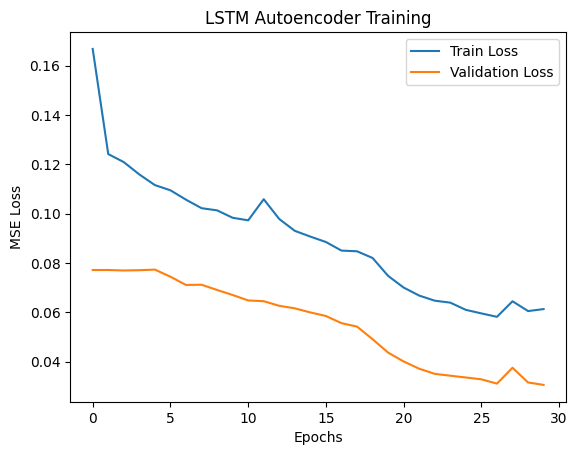

In [39]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("LSTM Autoencoder Training")
plt.show()

Por lo que refleja la gráfica, el loss del modelo en la validación es menor. Es un gran indicio de que el modelo es capaz de generalizar en los ejemplos más allá del conjunto de ```train``` y que no hay signos de overfitting.

In [29]:
# Validación y búsqueda rápida del umbral óptimo por percentiles
x_valid_pred = model_lstm.predict(x_valid_scaled)
valid_mae_loss = np.mean(np.abs(x_valid_pred - x_valid_scaled), axis=(1, 2))

# Buscar en percentiles altos
percentiles = np.linspace(98, 99.99, 500)  # rango amplio, buena resolución
best_f05, best_thr = -1, None

for p in percentiles:
    thr = np.percentile(valid_mae_loss, p)
    y_pred = (valid_mae_loss > thr).astype(int)
    f05 = event_wise_fbeta_score(y_valid, y_pred, beta=0.5)
    if f05 > best_f05:
        best_f05, best_thr = f05, thr

print(f"Mejor threshold: {best_thr:.6f}. F0.5 = {best_f05:.4f}")

3124/3124 [==============================] - 16s 5ms/step
Mejor threshold: 0.195761. F0.5 = 0.4285


Predicción y generación archivo CSV

In [ ]:
# Predicción por bloques
def batch_predict(model, x, batch_size=1024):
    preds = []
    for i in range(0, len(x), batch_size):
        batch = x[i:i+batch_size]
        if len(batch) < batch_size:
            pad_len = batch_size - len(batch)
            batch_padded = np.pad(batch, ((0, pad_len), (0, 0), (0, 0)), mode='edge')
            pred = model.predict(batch_padded, verbose=0)[:len(batch)]
        else:
            pred = model.predict(batch, verbose=0)
        preds.append(pred)
    return np.concatenate(preds, axis=0)

# Predicción
x_test_pred = batch_predict(model_lstm, x_test_scaled, batch_size=1024)

# Cálculo del error MAE 
test_mae_loss = np.mean(np.abs(x_test_pred - x_test_scaled), axis=(1, 2))

# Clasificación binaria según el umbral
anomaly_flags = (test_mae_loss > 0.174185).astype(int)

y_pred_test = np.zeros(len(df_test), dtype=int)
for i in range(len(anomaly_flags)):
    idx = i + W - 1
    if idx < len(y_pred_test):
        y_pred_test[idx] = 1

# Submission
submission = pd.DataFrame({
    "id": df_test["id"],
    "is_anomaly": y_pred_test
})
submission.to_csv("submission_lstm2.csv", index=False)
print("✅ Archivo submission_lstm2.csv generado.")

✅ Archivo submission_lstm2.csv generado.


#### Convolucional Autoencoder (Public Score: 0.699)

Basado en https://keras.io/examples/timeseries/timeseries_anomaly_detection/

In [21]:
model_conv = keras.Sequential([
    layers.Input(shape=(W, len(starter_ch))),
    layers.Conv1D(32, kernel_size=7, padding="same", strides=2, activation="relu"),
    layers.Dropout(0.2),
    layers.Conv1D(16, kernel_size=7, padding="same", strides=2, activation="relu"),
    layers.Conv1DTranspose(16, kernel_size=7, padding="same", strides=2, activation="relu"),
    layers.Dropout(0.2),
    layers.Conv1DTranspose(32, kernel_size=7, padding="same", strides=2, activation="relu"),
    layers.Conv1DTranspose(len(starter_ch), kernel_size=7, padding="same")
])
model_conv.compile(optimizer=keras.optimizers.Adam(0.001), loss="mse")
model_conv.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 30, 32)            1376      
                                                                 
 dropout (Dropout)           (None, 30, 32)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 15, 16)            3600      
                                                                 
 conv1d_transpose (Conv1DTra  (None, 30, 16)           1808      
 nspose)                                                         
                                                                 
 dropout_1 (Dropout)         (None, 30, 16)            0         
                                                                 
 conv1d_transpose_1 (Conv1DT  (None, 60, 32)           3616      
 ranspose)                                              

In [22]:
history = model_conv.fit(
    x_train_scaled, x_train_scaled,
    epochs=30,
    batch_size=64,
    validation_data=(x_valid_scaled, x_valid_scaled),
    verbose=1
)

Epoch 1/30
14062/14062 [==============================] - 56s 4ms/step - loss: 0.0908 - val_loss: 0.0173
Epoch 2/30
14062/14062 [==============================] - 52s 4ms/step - loss: 0.0481 - val_loss: 0.0161
Epoch 3/30
14062/14062 [==============================] - 53s 4ms/step - loss: 0.0403 - val_loss: 0.0187
Epoch 4/30
14062/14062 [==============================] - 54s 4ms/step - loss: 0.0341 - val_loss: 0.0180
Epoch 5/30
14062/14062 [==============================] - 52s 4ms/step - loss: 0.0281 - val_loss: 0.0201
Epoch 6/30
14062/14062 [==============================] - 53s 4ms/step - loss: 0.0269 - val_loss: 0.0200
Epoch 7/30
14062/14062 [==============================] - 51s 4ms/step - loss: 0.0244 - val_loss: 0.0201
Epoch 8/30
14062/14062 [==============================] - 51s 4ms/step - loss: 0.0240 - val_loss: 0.0224
Epoch 9/30
14062/14062 [==============================] - 50s 4ms/step - loss: 0.0229 - val_loss: 0.0203
Epoch 10/30
14062/14062 [==============================

In [23]:
# Guardar el modelo completo en un archivo .h5
model_conv.save("conv.h5")

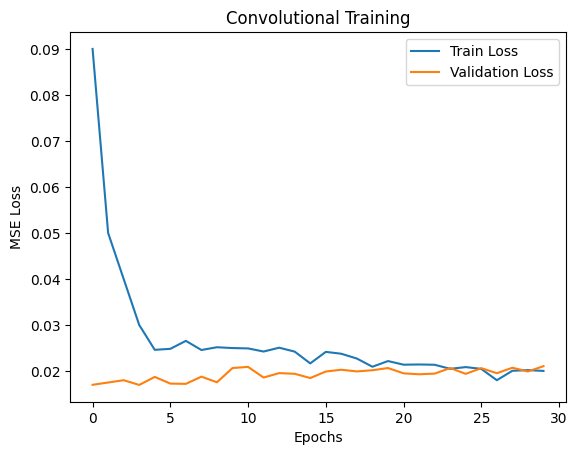

In [ ]:
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Convolucional Training")
plt.show()

In [30]:
# Validación y búsqueda rápida del umbral óptimo por percentiles
x_valid_pred = model_conv.predict(x_valid_scaled)
valid_mae_loss = np.mean(np.abs(x_valid_pred - x_valid_scaled), axis=(1, 2))

# Buscar en percentiles altos
percentiles = np.linspace(98, 99.99, 500)  # rango amplio, buena resolución
best_f05, best_thr = -1, None

for p in percentiles:
    thr = np.percentile(valid_mae_loss, p)
    y_pred = (valid_mae_loss > thr).astype(int)
    f05 = event_wise_fbeta_score(y_valid, y_pred, beta=0.5)
    if f05 > best_f05:
        best_f05, best_thr = f05, thr

print(f"Mejor threshold: {best_thr:.6f}. F0.5 = {best_f05:.4f}")

3124/3124 [==============================] - 5s 1ms/step
Mejor threshold: 0.128938. F0.5 = 0.4838


In [27]:
# 1️⃣ Reconstrucción del test
x_test_pred = batch_predict(model_conv, x_test_scaled, batch_size=1024)

# 2️⃣ Cálculo del error MAE por ventana
test_mae_loss = np.mean(np.abs(x_test_pred - x_test_scaled), axis=(1, 2))

# 3️⃣ Clasificación binaria según el umbral óptimo
anomaly_flags = (test_mae_loss > 0.124395).astype(int)

# 4️⃣ Expandir predicciones al último punto de cada ventana
y_pred_test = np.zeros(len(df_test), dtype=int)
for i in range(len(anomaly_flags)):
    idx = i + W - 1
    if idx < len(y_pred_test):
        y_pred_test[idx] = 1

# 5️⃣ Guardar archivo de submission
submission = pd.DataFrame({
    "id": df_test["id"],
    "is_anomaly": y_pred_test
})
submission.to_csv("submission_conv2.csv", index=False)
print("Archivo submission_conv2.csv generado.")

Archivo submission_conv2.csv generado.


## 📝 Registro de intentos

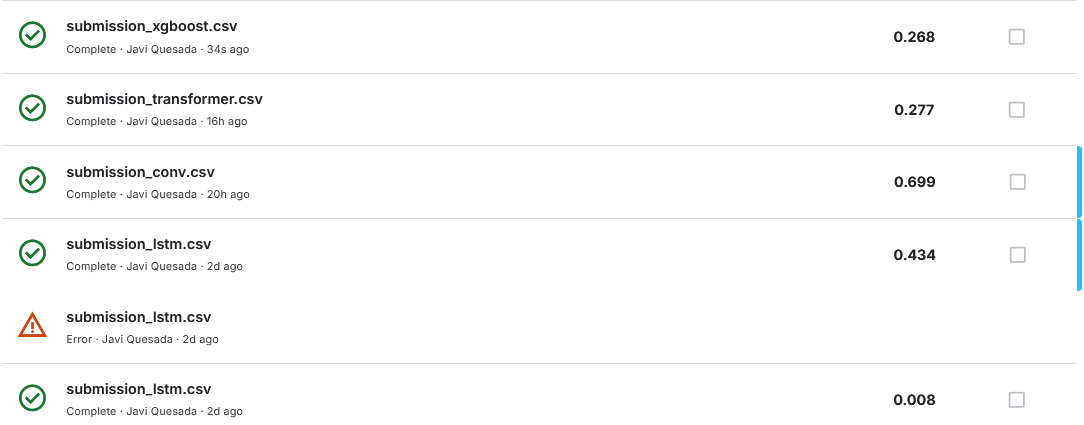

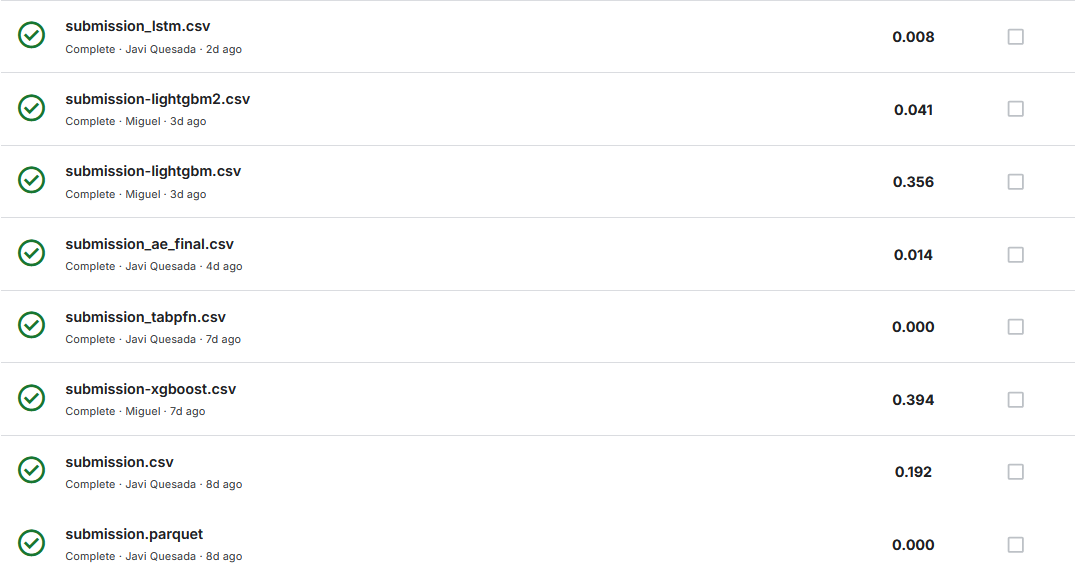

In [3]:
from IPython.display import Image, display

display(Image("Screenshot_2.png"))
display(Image("Screenshot_1.png"))